In [1]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [2]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import PreprocessSMILES, SimpleRegressions, SmallNN, LstmRegressor, DataLoader, Training

from utils import load_config, seed_everything

import gensim

print(gensim.__version__) # 3.7.1

2024-04-21 03:08:49.690386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 03:08:50.788795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-21 03:08:50.788965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-21 03:08:50.788976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

3.7.1


## Майнинг данных из SMILES и объединение молекул в смеси

In [4]:
############################################################################################################################################
directory = './materials/'
preprocessor = PreprocessSMILES(directory, 'canonical_smiles')
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv", "descriptors.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf)
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df.reset_index(drop=True, inplace=True)
mdf['graphs'] = preprocessor.generate_graphs(mdf)
mdf.drop(columns=['oil_property_param_title', 'oil_property_param_value', 'mol'], inplace=True)
joined_df.head(3)
# X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.bias', 'regression.out_proj.weight', 'norm_std', 'regression.out_proj.bias', 'regression.dense.weight', 'norm_mean']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,oil_property_param_title,canonical_smiles,smiles,oil_property_param_value,similarity_vectors,embeddings
0,007b4d7a-b1f8-11ed-93b4-005056921581,"[2246728737, 3537119515, 2245273601, 242354360...","[-3.4431674, -0.62736166, -2.157891, -0.715889...",ad7e6027-00b8-4c27-918c-d1561f949ad8,"CCCCCC(C)C, CCCC(C)CCC, CCCCC","CC(C)CCCCC, CCCC(C)CCC, CCCCC",13360.0,"[0.3888888888888889, 0.4, 0.2857142857142857]","[0.08706273138523102, 0.03486892580986023, -0...."
1,0109d480-f91d-11ec-96ac-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-5.5208826, 0.3777768, -3.6566508, -1.7744193...",ad7e6027-00b8-4c27-918c-d1561f949ad8,"CCCCC(C)CC, CCCC(C)CCC, CCCCC, CCCCC(C)C, CCCC...","CCC(C)CCCC, CCCC(C)CCC, CCCCC, CCCCC(C)C, O=C(...",111400.0,"[0.4444444444444444, 0.375, 0.5555555555555556...","[0.07872331887483597, 0.058090705424547195, -0..."
2,01bc9ed0-0f2f-11ed-9900-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-2.5844321, 0.054932743, -2.082138, -0.734171...",ad7e6027-00b8-4c27-918c-d1561f949ad8,"CCC(CC)C(=O)OC, CCCC(C)CCC, CCCCC","CCC(C(OC)=O)CC, CCCC(C)CCC, CCCCC",16325.0,"[0.16666666666666666, 0.14285714285714285, 0.2...","[0.05743774026632309, 0.021375086158514023, -0..."


In [5]:
# TODO: пример графа, на данный момент не используется

mdf['graphs'][0]

Graph(num_nodes=8, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

## Подготовка данных для обучения на объединенных последовательностях векторов, эмбедингов смеси и близости расстояний между молекулами.


In [6]:
# как similarity_score используется TanimotoSimilarity из rdkit

static_cols = ['mol2vec', 'embeddings']
dynamic_cols = ['similarity_vectors']

data_loader = DataLoader(joined_df, static_cols, dynamic_cols)
dataset = data_loader.get_dataset()

Shape of data_x: (338, 1, 690)
Shape of data_y: (338, 1)


## Тренировка

-----Seed Set!-----

Split 1/3...
lr 0.01


BEST ----> 
ConvRegressor Epoch 0, train_loss 0.893, val_loss 0.764, val_mse 6149586944.0
BEST ----> 
ConvRegressor Epoch 1, train_loss 0.861, val_loss 0.749, val_mse 5877443072.0
ConvRegressor Epoch 2, train_loss 0.851, val_loss 0.752, val_mse 5922016768.0
ConvRegressor Epoch 3, train_loss 0.856, val_loss 0.753, val_mse 5936115712.0
ConvRegressor Epoch 4, train_loss 0.853, val_loss 0.751, val_mse 5924059648.0
ConvRegressor Epoch 5, train_loss 0.847, val_loss 0.755, val_mse 5985832960.0
ConvRegressor Epoch 6, train_loss 0.853, val_loss 0.758, val_mse 6039244800.0
BEST ----> 
ConvRegressor Epoch 7, train_loss 0.854, val_loss 0.744, val_mse 5834274816.0
ConvRegressor Epoch 8, train_loss 0.837, val_loss 0.748, val_mse 5889243136.0
ConvRegressor Epoch 9, train_loss 0.86, val_loss 0.774, val_mse 6314648064.0
ConvRegressor Epoch 10, train_loss 0.862, val_loss 0.758, val_mse 6056963584.0
ConvRegressor Epoch 11, train_loss 0.841, val_loss 0.76, val_mse 6087653888.0
ConvRegressor Epoch 12, trai

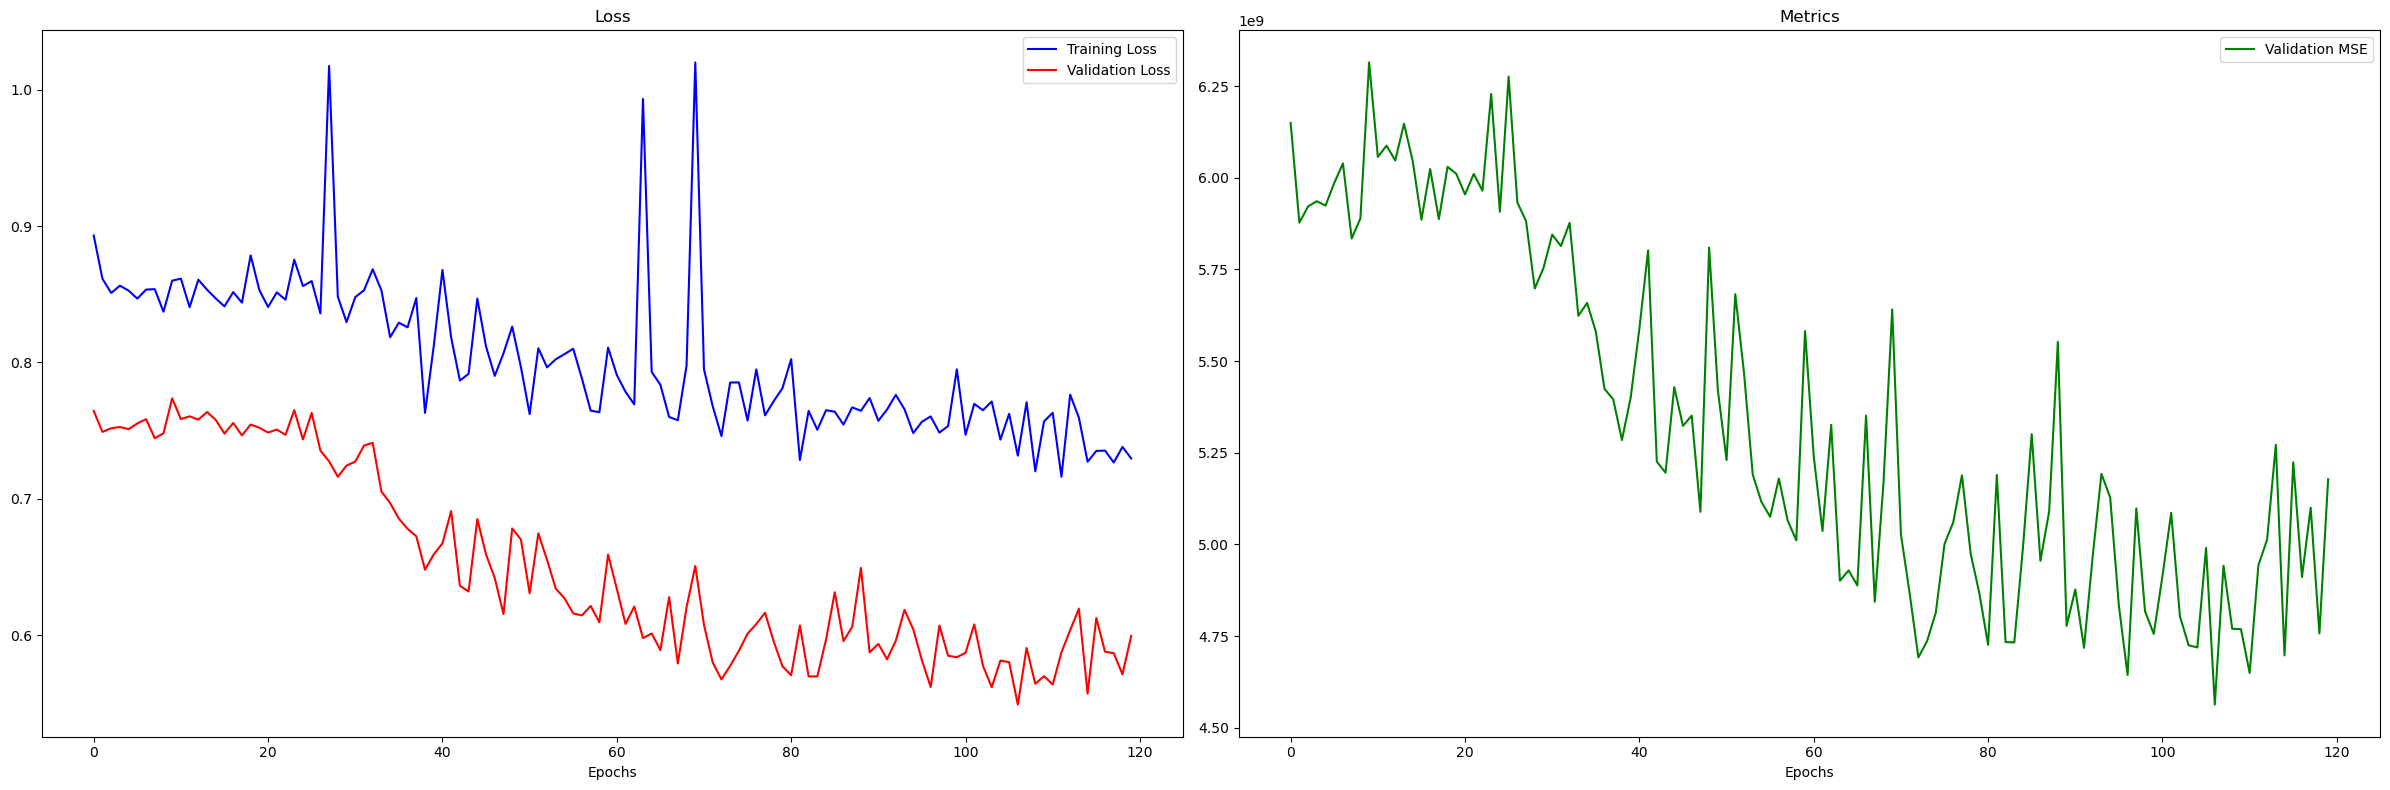

lr 0.01
BEST ----> 
LSTMRegressor Epoch 0, train_loss 0.87, val_loss 0.811, val_mse 6443928576.0
BEST ----> 
LSTMRegressor Epoch 1, train_loss 0.838, val_loss 0.711, val_mse 6106190848.0
LSTMRegressor Epoch 2, train_loss 0.79, val_loss 0.8, val_mse 7225328640.0
BEST ----> 
LSTMRegressor Epoch 3, train_loss 0.781, val_loss 0.581, val_mse 4899545088.0
BEST ----> 
LSTMRegressor Epoch 4, train_loss 0.754, val_loss 0.561, val_mse 4728916992.0
LSTMRegressor Epoch 5, train_loss 0.71, val_loss 0.557, val_mse 4760104448.0
BEST ----> 
LSTMRegressor Epoch 6, train_loss 0.676, val_loss 0.554, val_mse 4246805760.0
LSTMRegressor Epoch 7, train_loss 0.702, val_loss 0.738, val_mse 6556511744.0
LSTMRegressor Epoch 8, train_loss 0.736, val_loss 0.625, val_mse 5272836608.0
LSTMRegressor Epoch 9, train_loss 0.769, val_loss 0.615, val_mse 5217568768.0
LSTMRegressor Epoch 10, train_loss 0.732, val_loss 0.685, val_mse 6237312512.0
LSTMRegressor Epoch 11, train_loss 0.712, val_loss 0.543, val_mse 4784941568.0

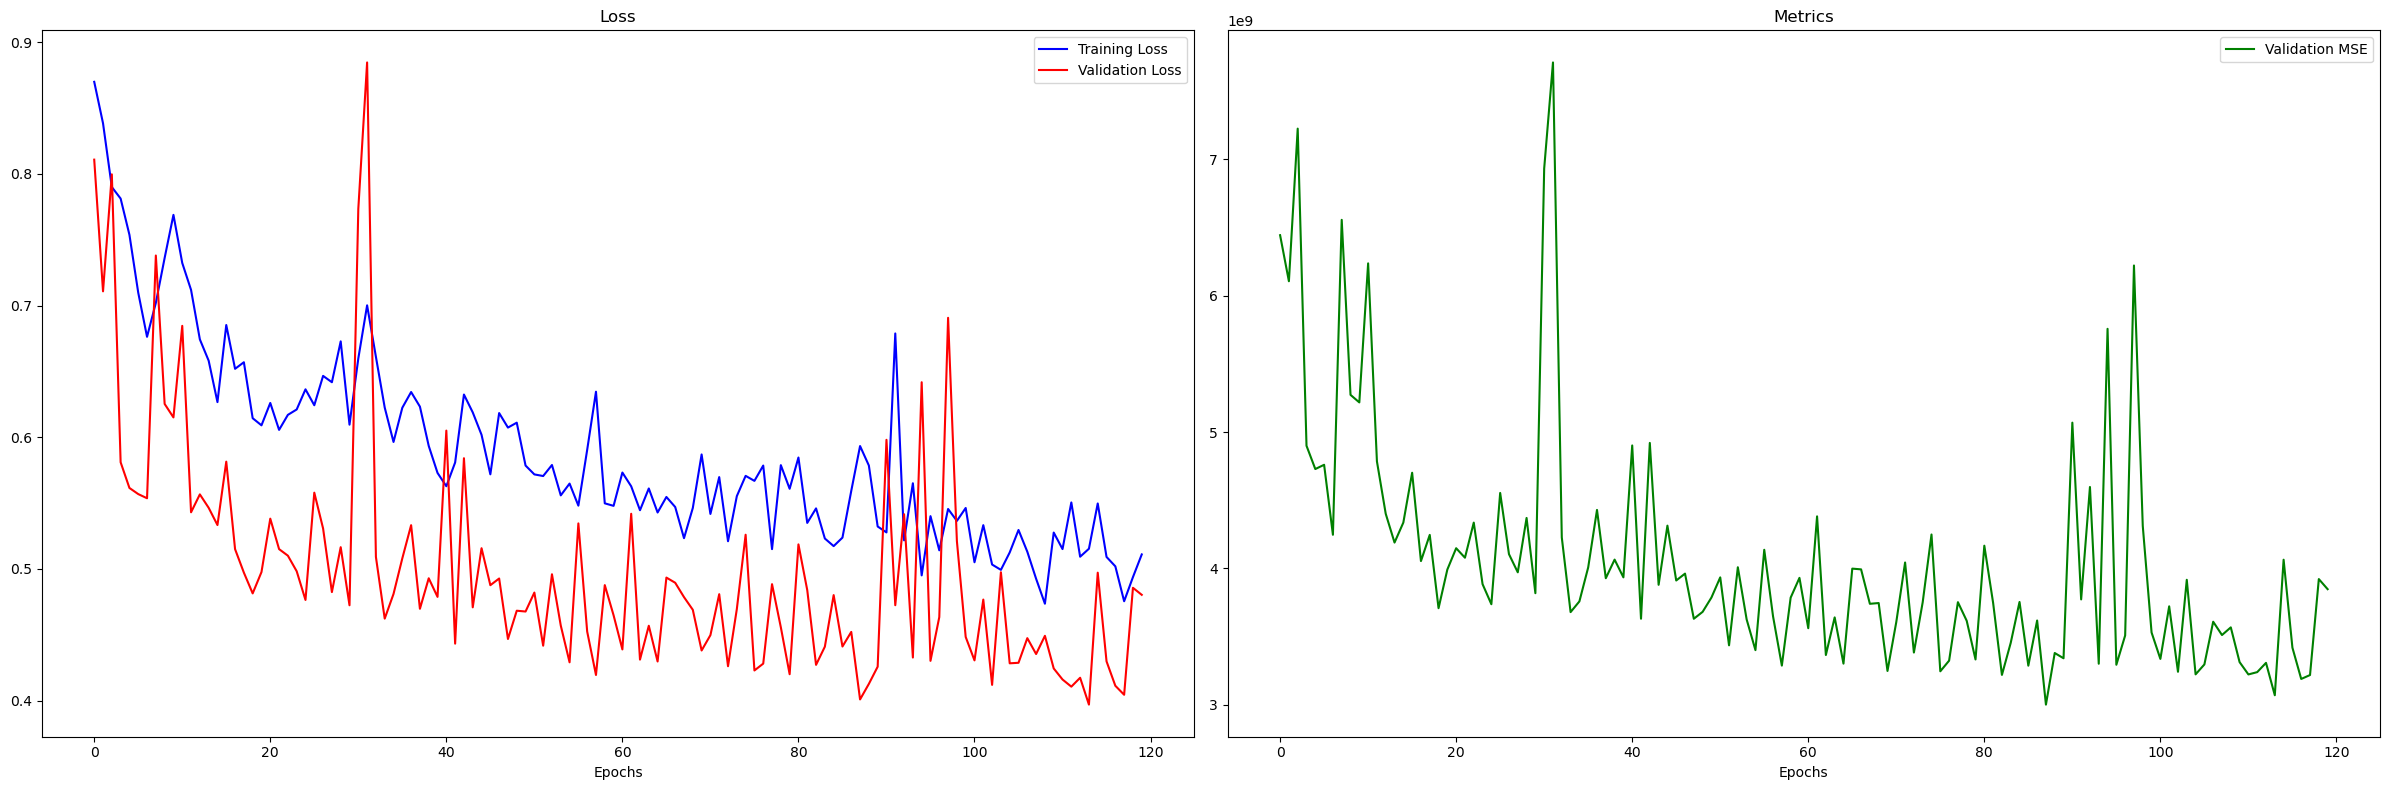


Split 2/3...
lr 0.01
BEST ----> 
ConvRegressor Epoch 0, train_loss 0.763, val_loss 0.948, val_mse 9223542784.0
BEST ----> 
ConvRegressor Epoch 1, train_loss 0.768, val_loss 0.937, val_mse 9198153728.0
ConvRegressor Epoch 2, train_loss 0.759, val_loss 0.935, val_mse 9210302464.0
ConvRegressor Epoch 3, train_loss 0.771, val_loss 0.934, val_mse 9218286592.0
ConvRegressor Epoch 4, train_loss 0.756, val_loss 0.934, val_mse 9230147584.0
ConvRegressor Epoch 5, train_loss 0.752, val_loss 0.933, val_mse 9255290880.0
ConvRegressor Epoch 6, train_loss 0.765, val_loss 0.934, val_mse 9226728448.0
ConvRegressor Epoch 7, train_loss 0.75, val_loss 0.934, val_mse 9232277504.0
ConvRegressor Epoch 8, train_loss 0.767, val_loss 0.933, val_mse 9252757504.0
ConvRegressor Epoch 9, train_loss 0.761, val_loss 0.934, val_mse 9224181760.0
ConvRegressor Epoch 10, train_loss 0.765, val_loss 0.933, val_mse 9250384896.0
ConvRegressor Epoch 11, train_loss 0.747, val_loss 0.933, val_mse 9237044224.0
ConvRegressor Epo

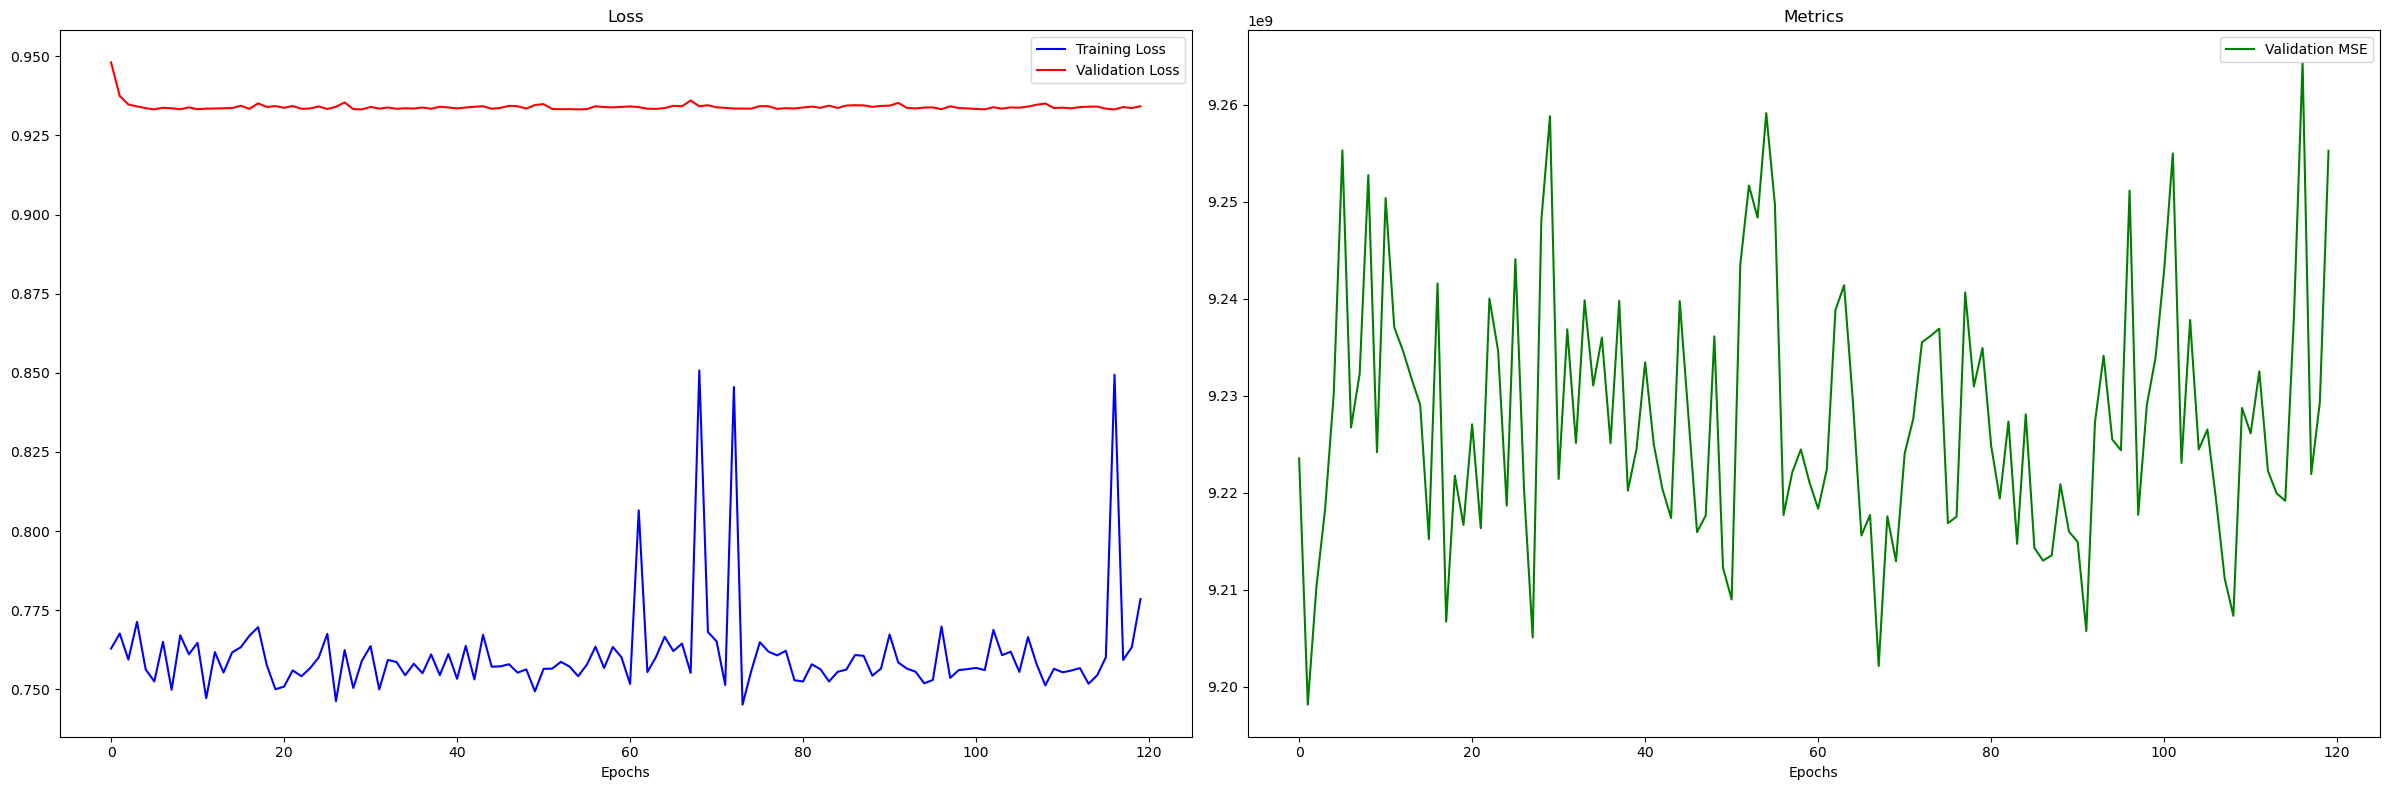

lr 0.01
BEST ----> 
LSTMRegressor Epoch 0, train_loss 0.75, val_loss 0.897, val_mse 9189838848.0
LSTMRegressor Epoch 1, train_loss 0.697, val_loss 0.925, val_mse 9532193792.0
BEST ----> 
LSTMRegressor Epoch 2, train_loss 0.711, val_loss 0.858, val_mse 8664550400.0
LSTMRegressor Epoch 3, train_loss 0.618, val_loss 1.067, val_mse 10576229376.0
BEST ----> 
LSTMRegressor Epoch 4, train_loss 0.661, val_loss 0.793, val_mse 8426285056.0
LSTMRegressor Epoch 5, train_loss 0.584, val_loss 0.795, val_mse 8848658432.0
LSTMRegressor Epoch 6, train_loss 0.62, val_loss 0.763, val_mse 8556610560.0
BEST ----> 
LSTMRegressor Epoch 7, train_loss 0.587, val_loss 0.78, val_mse 8337438208.0
BEST ----> 
LSTMRegressor Epoch 8, train_loss 0.567, val_loss 0.74, val_mse 8146357760.0
LSTMRegressor Epoch 9, train_loss 0.56, val_loss 0.816, val_mse 8903855104.0
LSTMRegressor Epoch 10, train_loss 0.545, val_loss 0.788, val_mse 8265442816.0
LSTMRegressor Epoch 11, train_loss 0.562, val_loss 0.764, val_mse 8513630720.

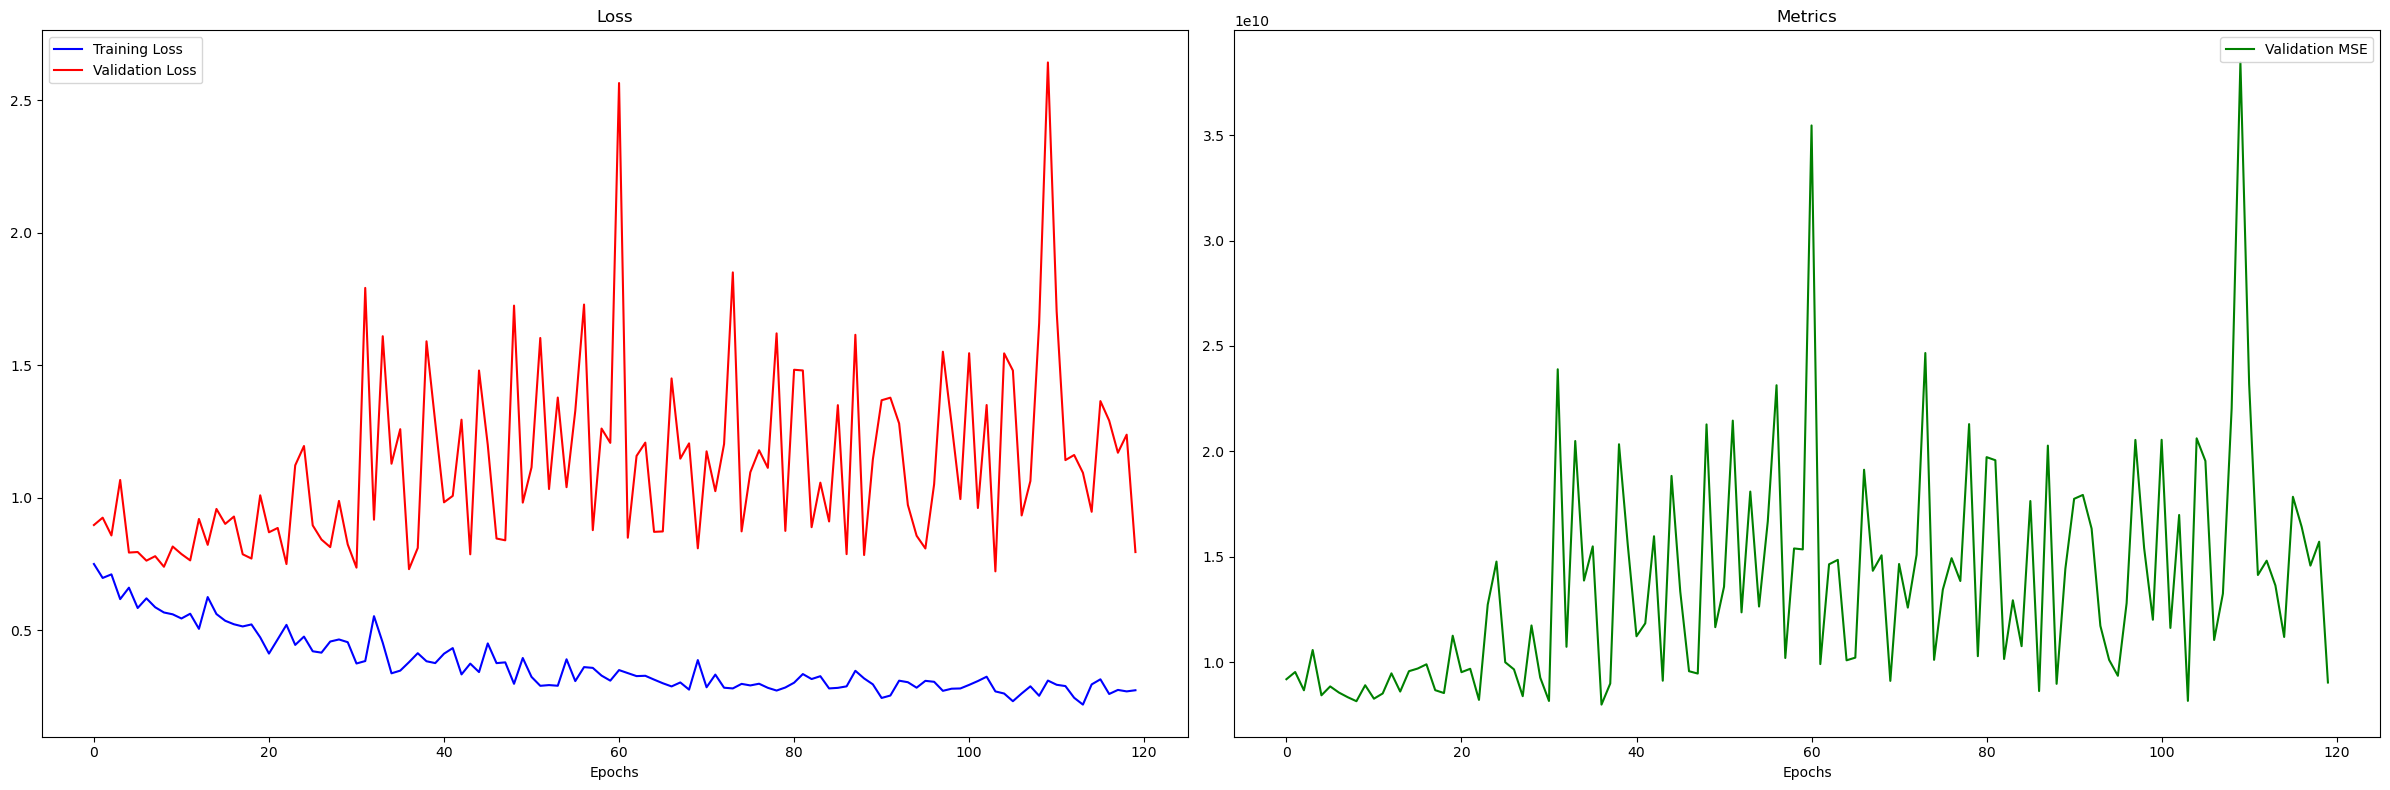


Split 3/3...
lr 0.01
BEST ----> 
ConvRegressor Epoch 0, train_loss 0.913, val_loss 0.783, val_mse 6326926336.0
BEST ----> 
ConvRegressor Epoch 1, train_loss 0.857, val_loss 0.767, val_mse 6224833024.0
ConvRegressor Epoch 2, train_loss 0.837, val_loss 0.766, val_mse 6254380032.0
ConvRegressor Epoch 3, train_loss 0.842, val_loss 0.763, val_mse 6253814272.0
ConvRegressor Epoch 4, train_loss 0.845, val_loss 0.764, val_mse 6230110208.0
ConvRegressor Epoch 5, train_loss 0.867, val_loss 0.765, val_mse 6255515136.0
ConvRegressor Epoch 6, train_loss 0.849, val_loss 0.765, val_mse 6275261952.0
BEST ----> 
ConvRegressor Epoch 7, train_loss 0.849, val_loss 0.764, val_mse 6207008256.0
ConvRegressor Epoch 8, train_loss 0.839, val_loss 0.764, val_mse 6221244928.0
BEST ----> 
ConvRegressor Epoch 9, train_loss 0.843, val_loss 0.762, val_mse 6206765056.0
BEST ----> 
ConvRegressor Epoch 10, train_loss 0.831, val_loss 0.762, val_mse 6189117440.0
BEST ----> 
ConvRegressor Epoch 11, train_loss 0.838, val_l

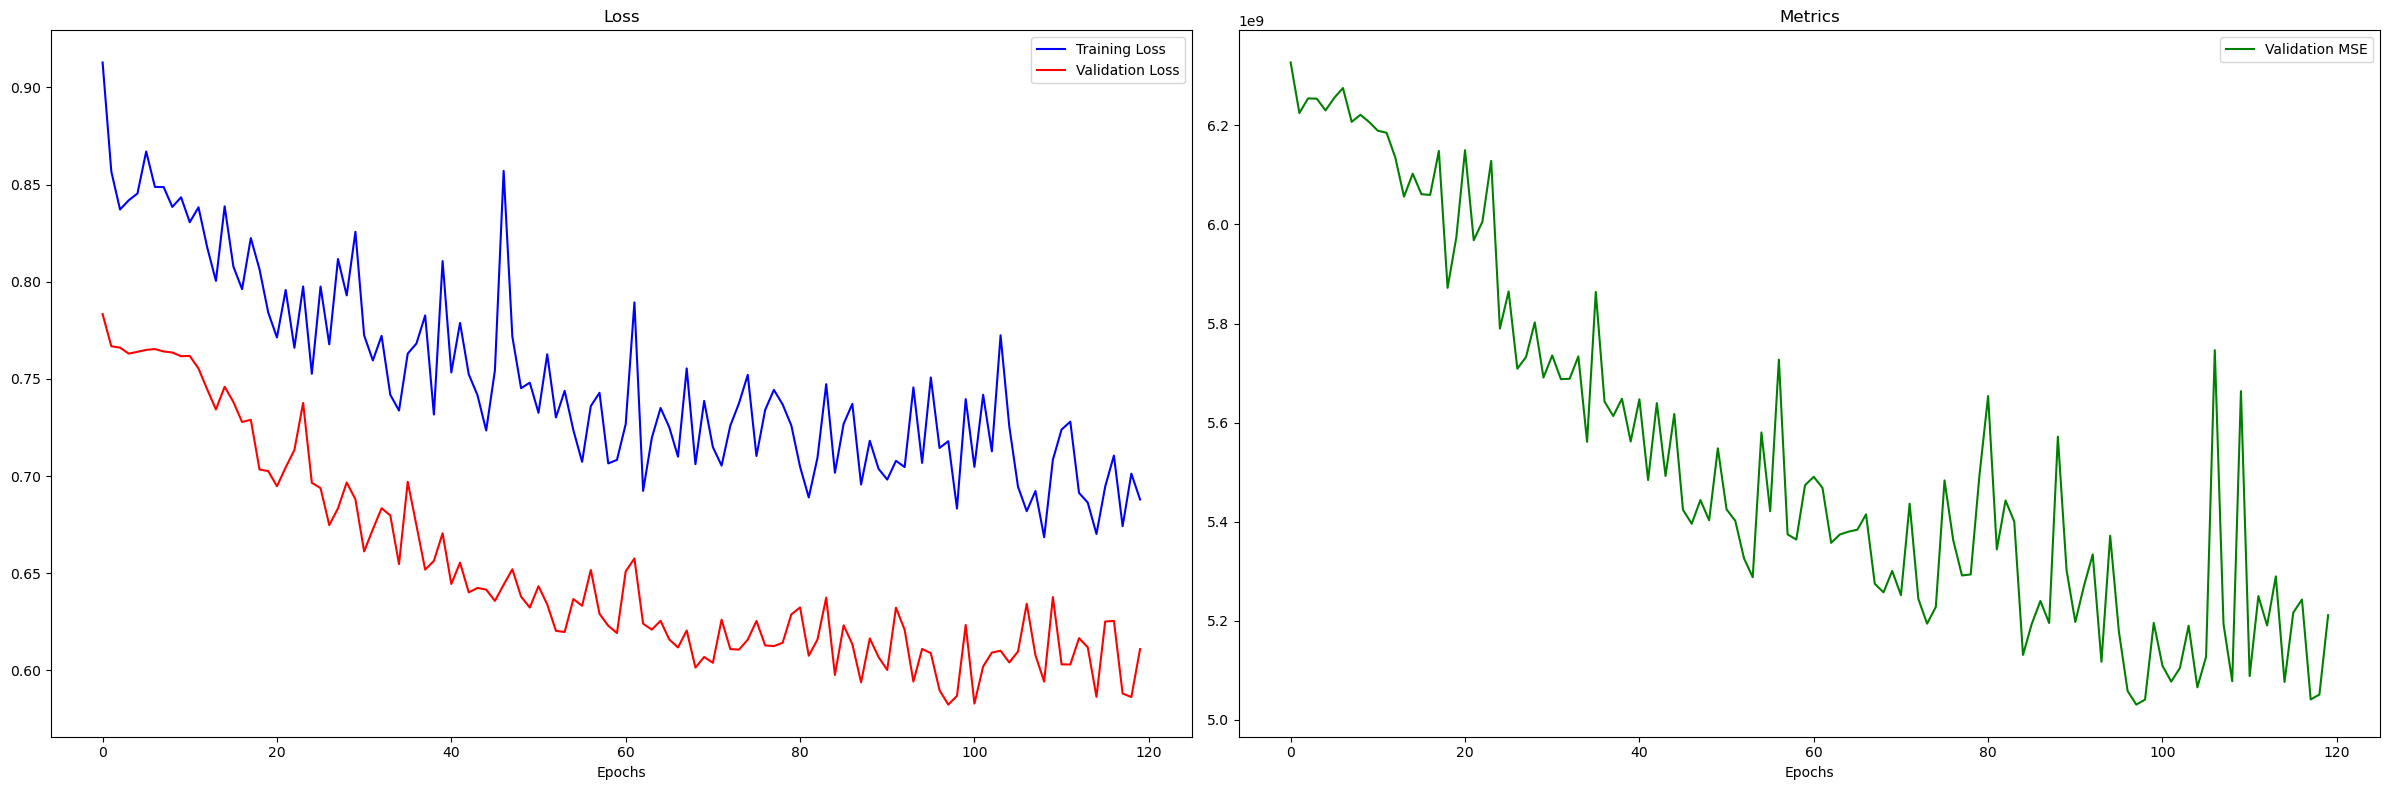

lr 0.01
BEST ----> 
LSTMRegressor Epoch 0, train_loss 0.869, val_loss 0.78, val_mse 6744496640.0
BEST ----> 
LSTMRegressor Epoch 1, train_loss 0.773, val_loss 0.733, val_mse 6036898816.0
LSTMRegressor Epoch 2, train_loss 0.783, val_loss 0.83, val_mse 7146620416.0
LSTMRegressor Epoch 3, train_loss 0.763, val_loss 0.78, val_mse 7333407744.0
LSTMRegressor Epoch 4, train_loss 0.732, val_loss 0.697, val_mse 6081687552.0
BEST ----> 
LSTMRegressor Epoch 5, train_loss 0.687, val_loss 0.616, val_mse 5666588672.0
BEST ----> 
LSTMRegressor Epoch 6, train_loss 0.794, val_loss 0.676, val_mse 5662291968.0
BEST ----> 
LSTMRegressor Epoch 7, train_loss 0.691, val_loss 0.591, val_mse 5076919808.0
LSTMRegressor Epoch 8, train_loss 0.682, val_loss 0.675, val_mse 5944184832.0
LSTMRegressor Epoch 9, train_loss 0.793, val_loss 0.625, val_mse 5502234624.0
LSTMRegressor Epoch 10, train_loss 0.649, val_loss 0.66, val_mse 6177083904.0
LSTMRegressor Epoch 11, train_loss 0.667, val_loss 0.641, val_mse 5201858560.

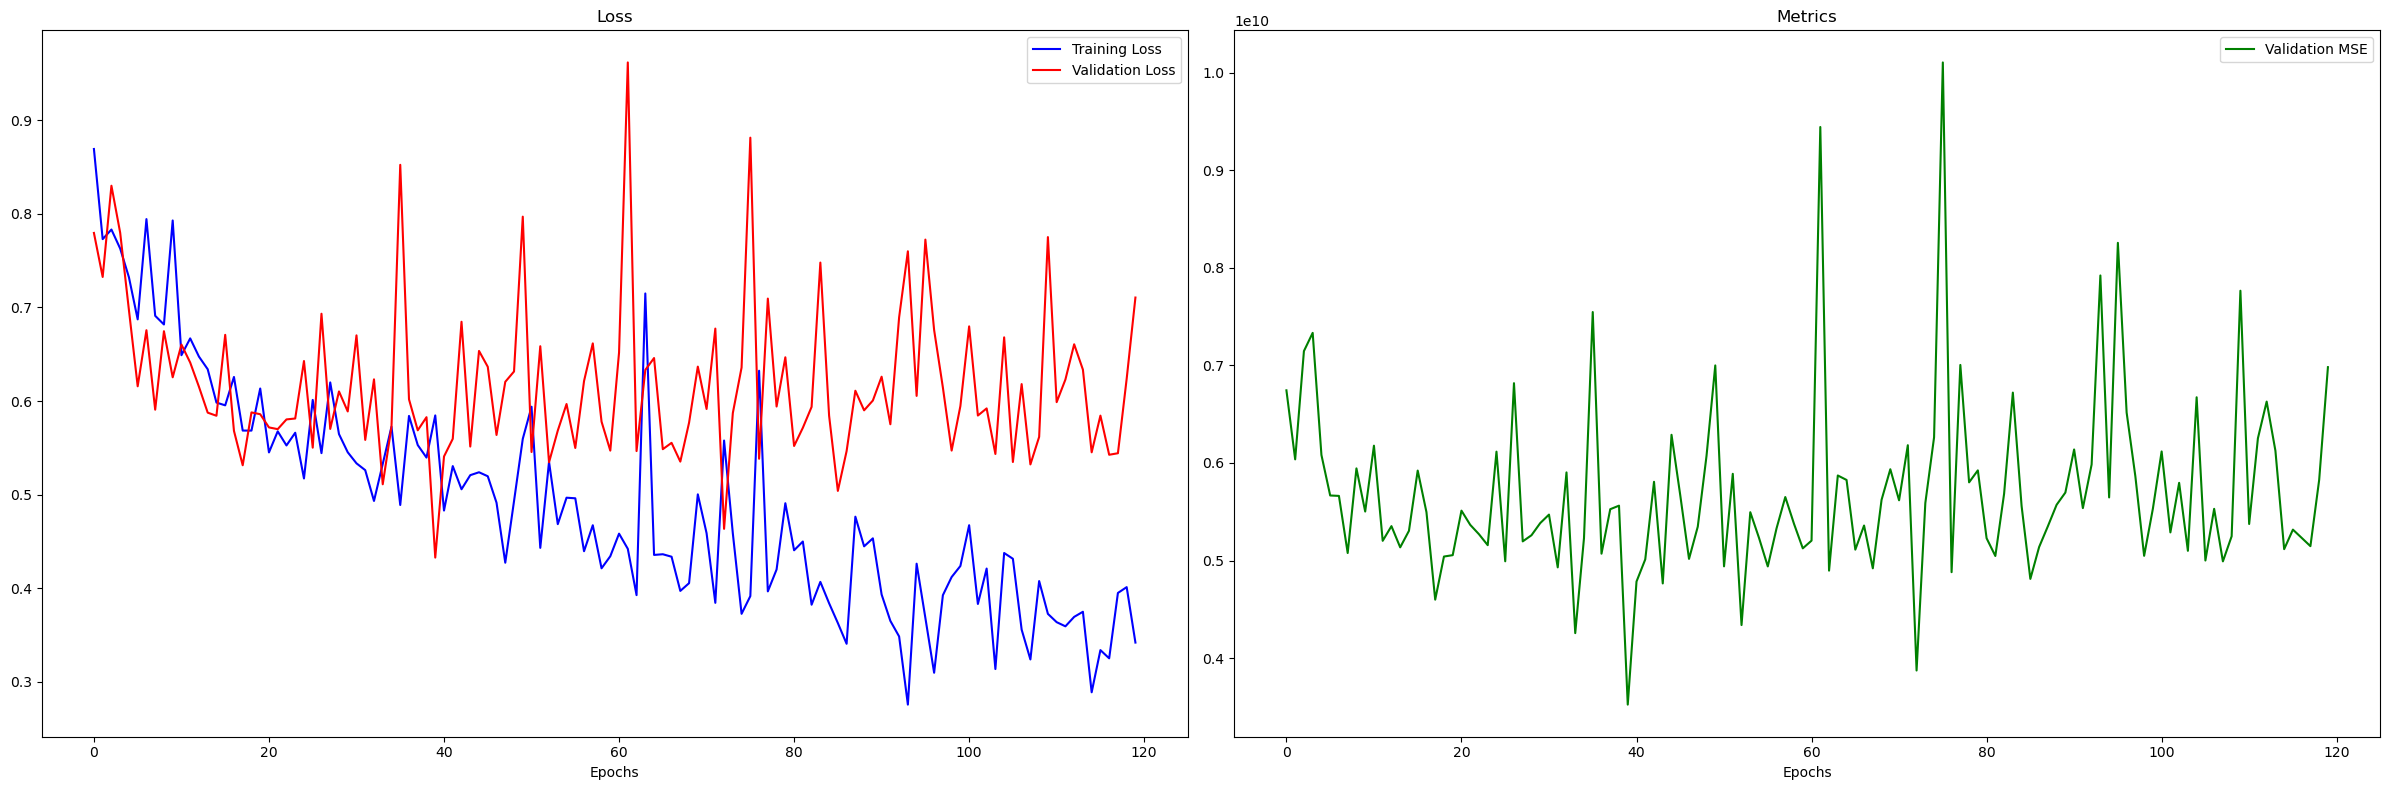

In [7]:
# Тренировка 3 архитектур нейросеток

config = load_config("config.yml", "LSTMRegressor")
seed_everything()
trainer = Training(config)
models = trainer.cross_validate_models(dataset.data_x, dataset.data_y)

# pred1 = trainer.average_prediction(test, models)
# pred2 = trainer.weighted_average_prediction(test, models, model_wise=[0.29, 0.33, 0.38], fold_wise=[0.30, 0.35, 0.35])

## Тренировка других моделей

Catboost
0:	learn: 0.9762163	test: 1.0155810	best: 1.0155810 (0)	total: 131ms	remaining: 2m 10s
1:	learn: 0.9517993	test: 0.9982781	best: 0.9982781 (1)	total: 177ms	remaining: 1m 28s
2:	learn: 0.9330530	test: 0.9900442	best: 0.9900442 (2)	total: 223ms	remaining: 1m 13s
3:	learn: 0.9154326	test: 0.9794474	best: 0.9794474 (3)	total: 248ms	remaining: 1m 1s
4:	learn: 0.8934902	test: 0.9649175	best: 0.9649175 (4)	total: 275ms	remaining: 54.7s
5:	learn: 0.8707461	test: 0.9457873	best: 0.9457873 (5)	total: 306ms	remaining: 50.7s
6:	learn: 0.8523196	test: 0.9391995	best: 0.9391995 (6)	total: 326ms	remaining: 46.3s
7:	learn: 0.8361489	test: 0.9256064	best: 0.9256064 (7)	total: 378ms	remaining: 46.9s
8:	learn: 0.8202576	test: 0.9123436	best: 0.9123436 (8)	total: 408ms	remaining: 44.9s
9:	learn: 0.8028782	test: 0.8881461	best: 0.8881461 (9)	total: 431ms	remaining: 42.7s
10:	learn: 0.7891372	test: 0.8775071	best: 0.8775071 (10)	total: 455ms	remaining: 40.9s
11:	learn: 0.7796875	test: 0.8710626	bes

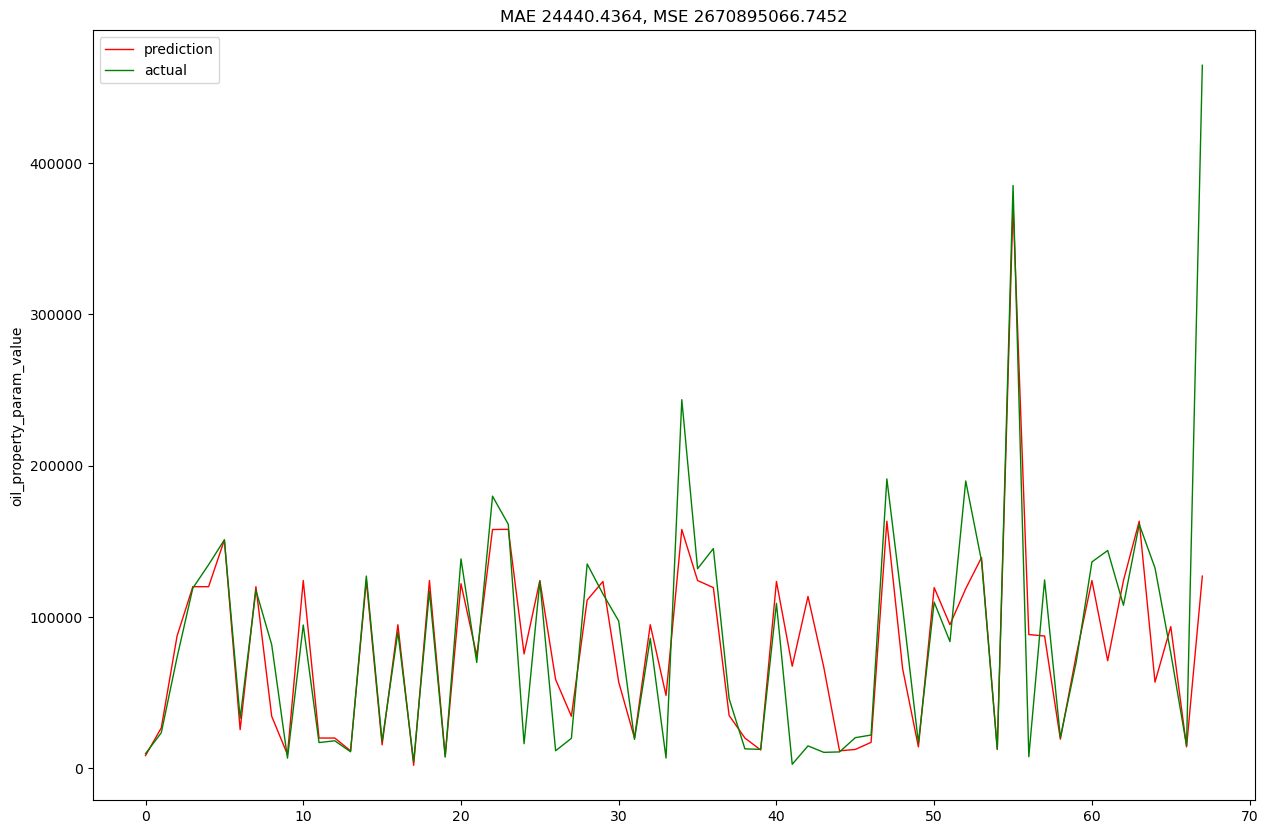

MAE score: 24440.4364
MSE score: 2670895066.7452
RandomForestRegressor


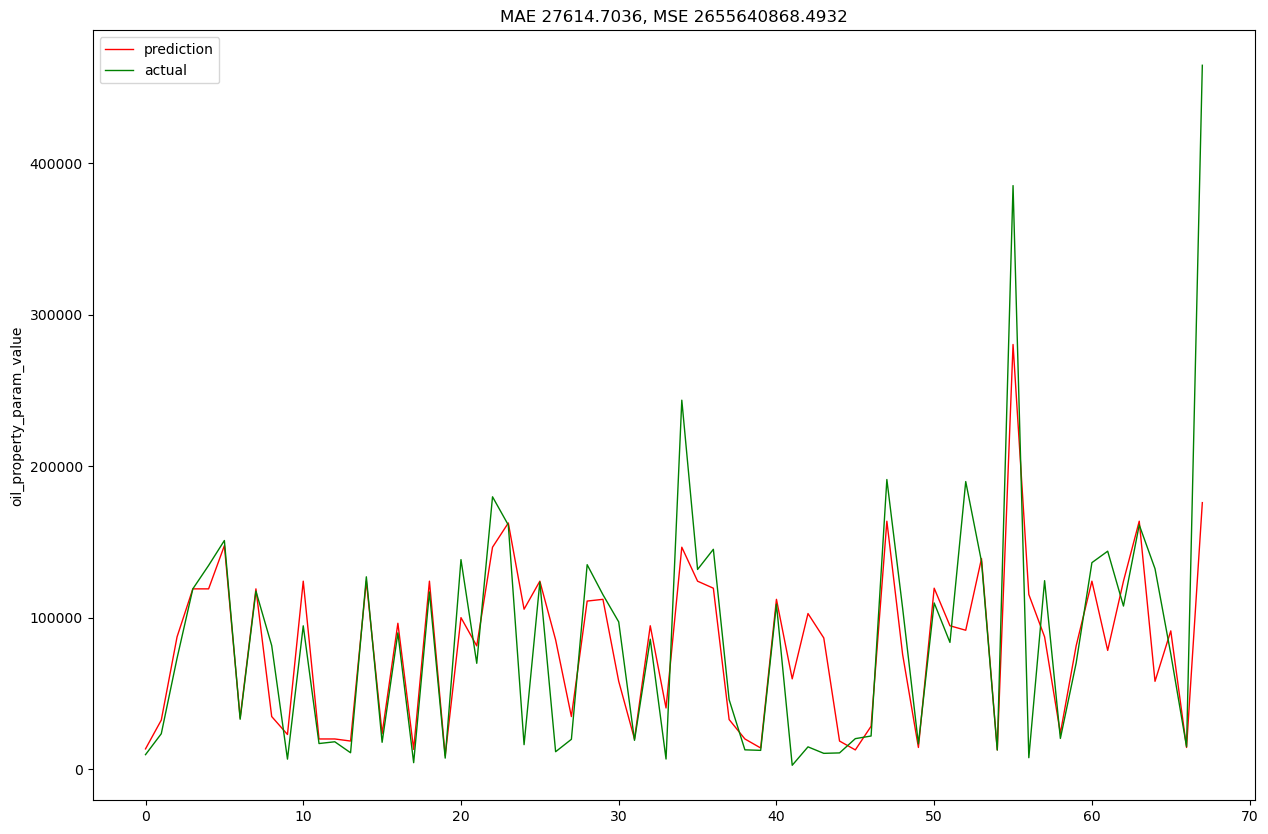

MAE score: 27614.7036
MSE score: 2655640868.4932
XGBRegressor
[0]	validation_0-rmse:0.99319
[1]	validation_0-rmse:0.94939


/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[2]	validation_0-rmse:0.91337
[3]	validation_0-rmse:0.87366
[4]	validation_0-rmse:0.83611
[5]	validation_0-rmse:0.81807
[6]	validation_0-rmse:0.78975
[7]	validation_0-rmse:0.76583
[8]	validation_0-rmse:0.75418
[9]	validation_0-rmse:0.73564
[10]	validation_0-rmse:0.72411
[11]	validation_0-rmse:0.71395
[12]	validation_0-rmse:0.70642
[13]	validation_0-rmse:0.69420
[14]	validation_0-rmse:0.69201
[15]	validation_0-rmse:0.68345
[16]	validation_0-rmse:0.67741
[17]	validation_0-rmse:0.67205
[18]	validation_0-rmse:0.66600
[19]	validation_0-rmse:0.66103
[20]	validation_0-rmse:0.65629
[21]	validation_0-rmse:0.65251
[22]	validation_0-rmse:0.65053
[23]	validation_0-rmse:0.64723
[24]	validation_0-rmse:0.64557
[25]	validation_0-rmse:0.64393
[26]	validation_0-rmse:0.64166
[27]	validation_0-rmse:0.64106
[28]	validation_0-rmse:0.63874
[29]	validation_0-rmse:0.63827
[30]	validation_0-rmse:0.63708
[31]	validation_0-rmse:0.63590
[32]	validation_0-rmse:0.63538
[33]	validation_0-rmse:0.63527
[34]	validation_

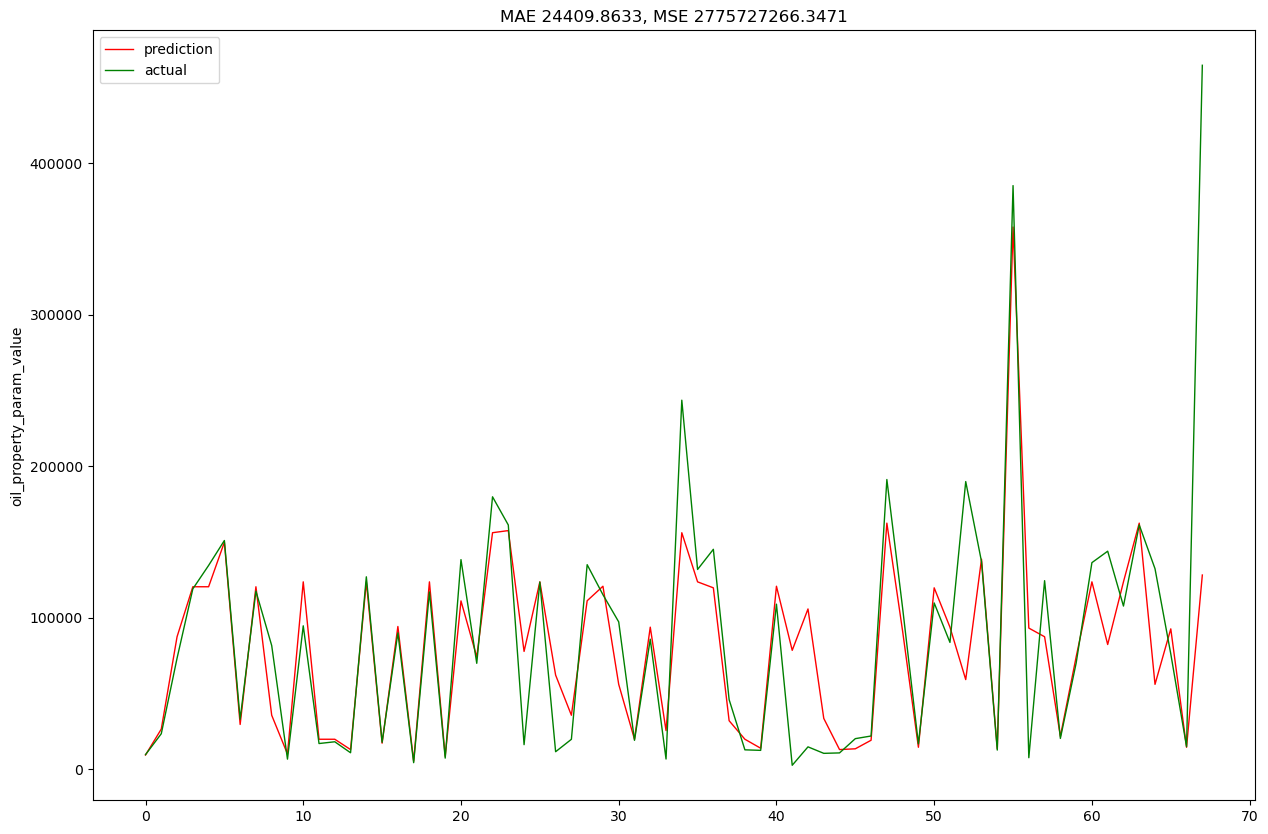

MAE score: 24409.8633
MSE score: 2775727266.3471
LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41216
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 690
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

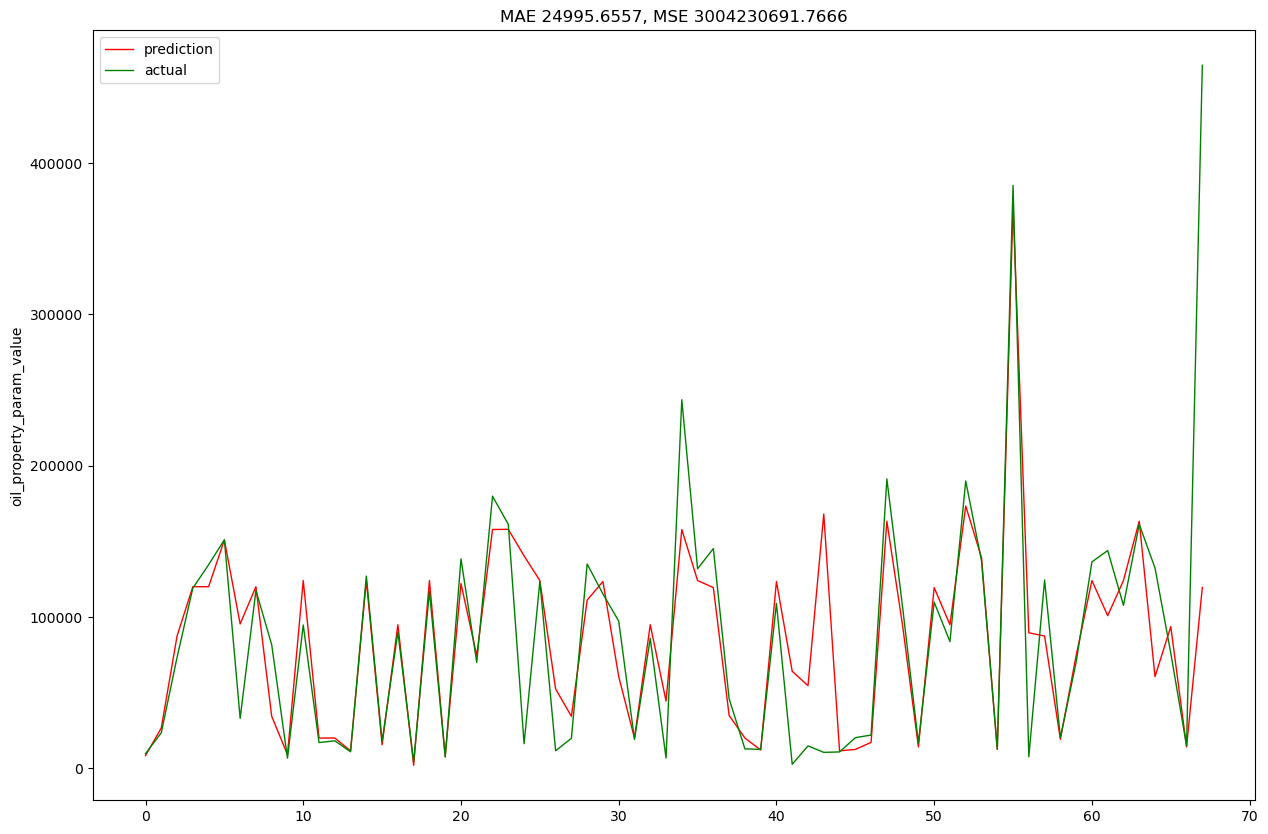

MAE score: 24995.6557
MSE score: 3004230691.7666
GradientBoostingRegressor


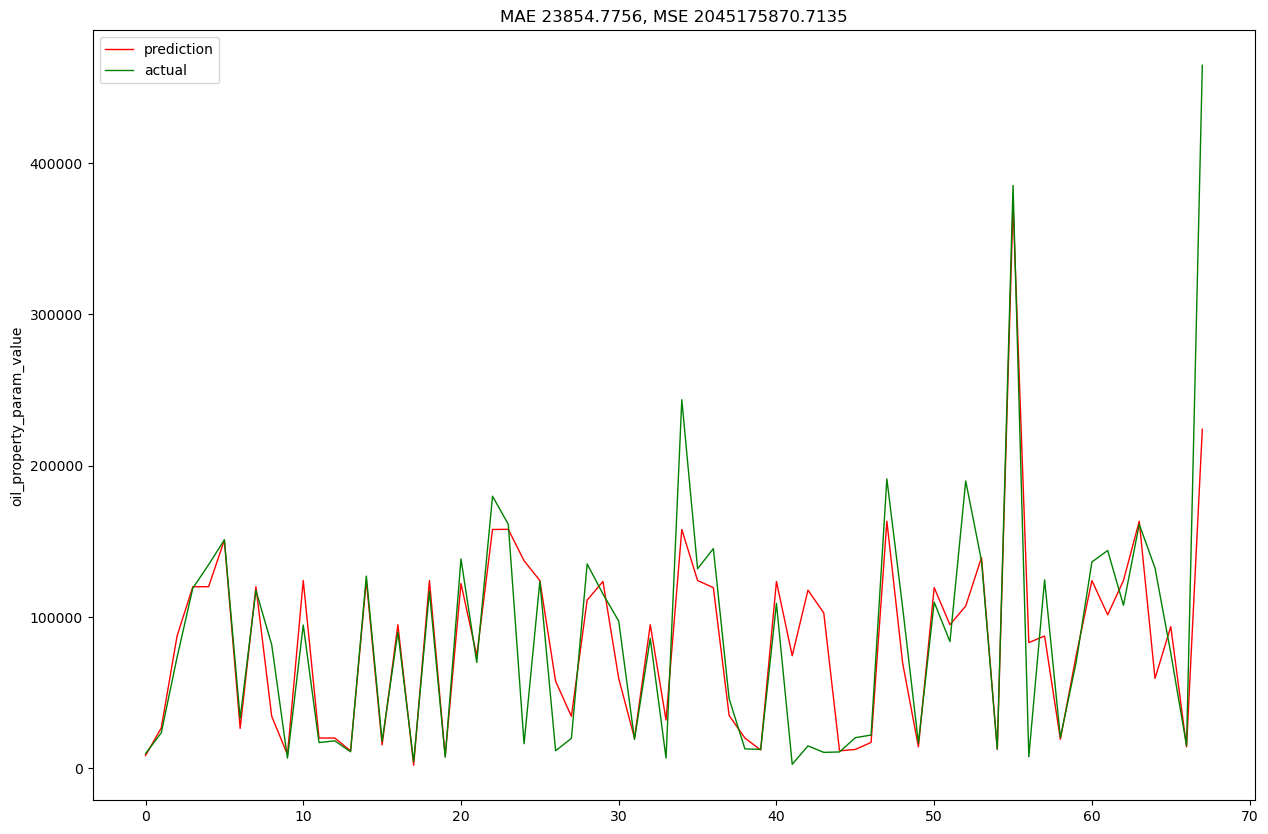

MAE score: 23854.7756
MSE score: 2045175870.7135
SVR


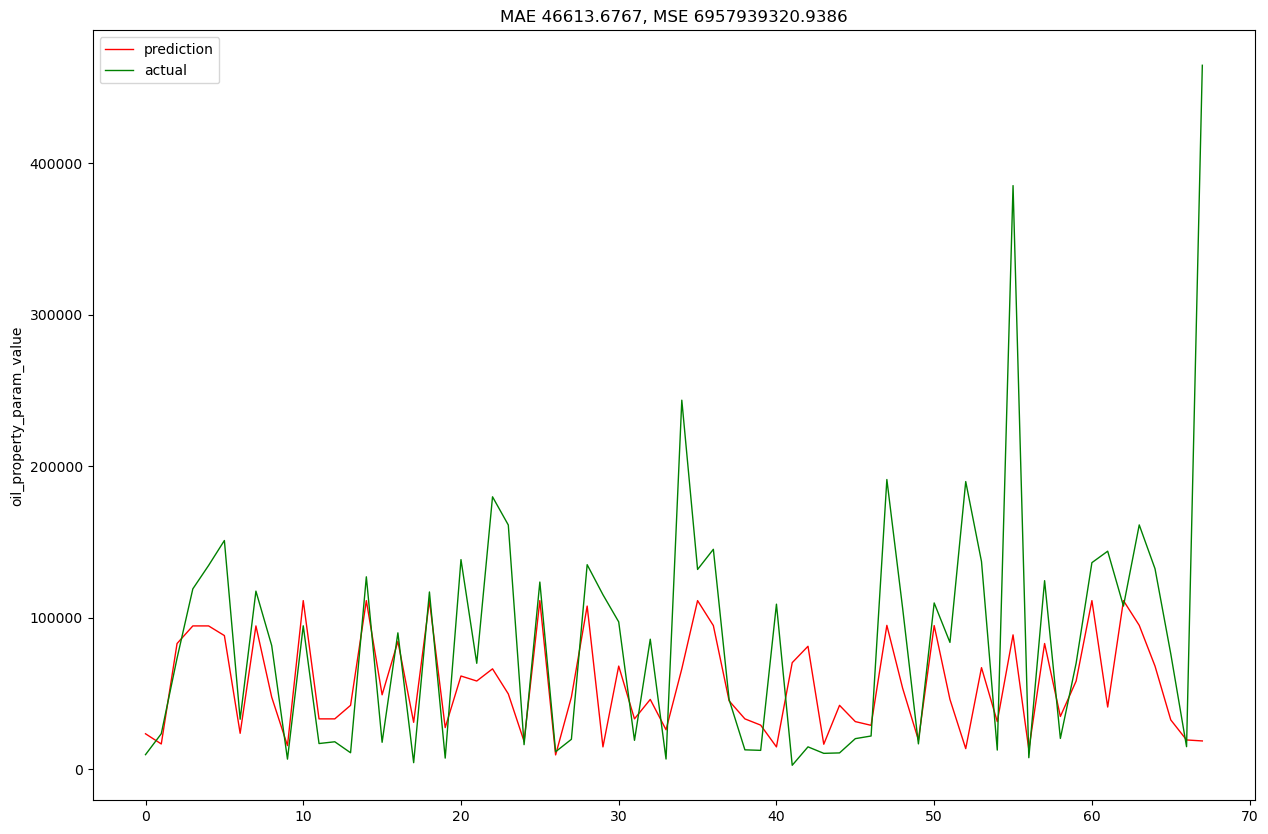

MAE score: 46613.6767
MSE score: 6957939320.9386


In [9]:
regression_models = SimpleRegressions(X=dataset.data_x.reshape(338, 690), y=dataset.data_y.reshape(338,))
regression_models.fit_and_evaluate()

2024-04-21 03:38:21.672614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-21 03:38:21.673699: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-21 03:38:21.674235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HPESRLBL): /proc/driver/nvidia/version does not exist
2024-04-21 03:38:21.683824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/400
4/4 [==============================] - 1s 145ms/step - loss: 10.2515 - mean_absolute_error: 2.5969 - val_loss: 7.4280 - val_mean_absolute_error: 2.5460 - lr: 0.0010
Epoch 2/400
4/4 [==============================] - 0s 16ms/step - loss: 3.9917 - mean_absolute_error: 1.5968 - val_loss: 1.9688 - val_mean_absolute_error: 1.2158 - lr: 0.0010
Epoch 3/400
4/4 [==============================] - 0s 16ms/step - loss: 1.1273 - mean_absolute_error: 0.8041 - val_loss: 1.7187 - val_mean_absolute_error: 1.0695 - lr: 0.0010
Epoch 4/400
4/4 [==============================] - 0s 15ms/step - loss: 1.1354 - mean_absolute_error: 0.7817 - val_loss: 0.6273 - val_mean_absolute_error: 0.6178 - lr: 0.0010
Epoch 5/400
4/4 [==============================] - 0s 16ms/step - loss: 0.6277 - mean_absolute_error: 0.6456 - val_loss: 0.3483 - val_mean_absolute_error: 0.3395 - lr: 0.0010
Epoch 6/400
4/4 [==============================] - 0s 20ms/step - loss: 0.2544 - mean_absolute_error: 0.3004 - val_loss: 0.

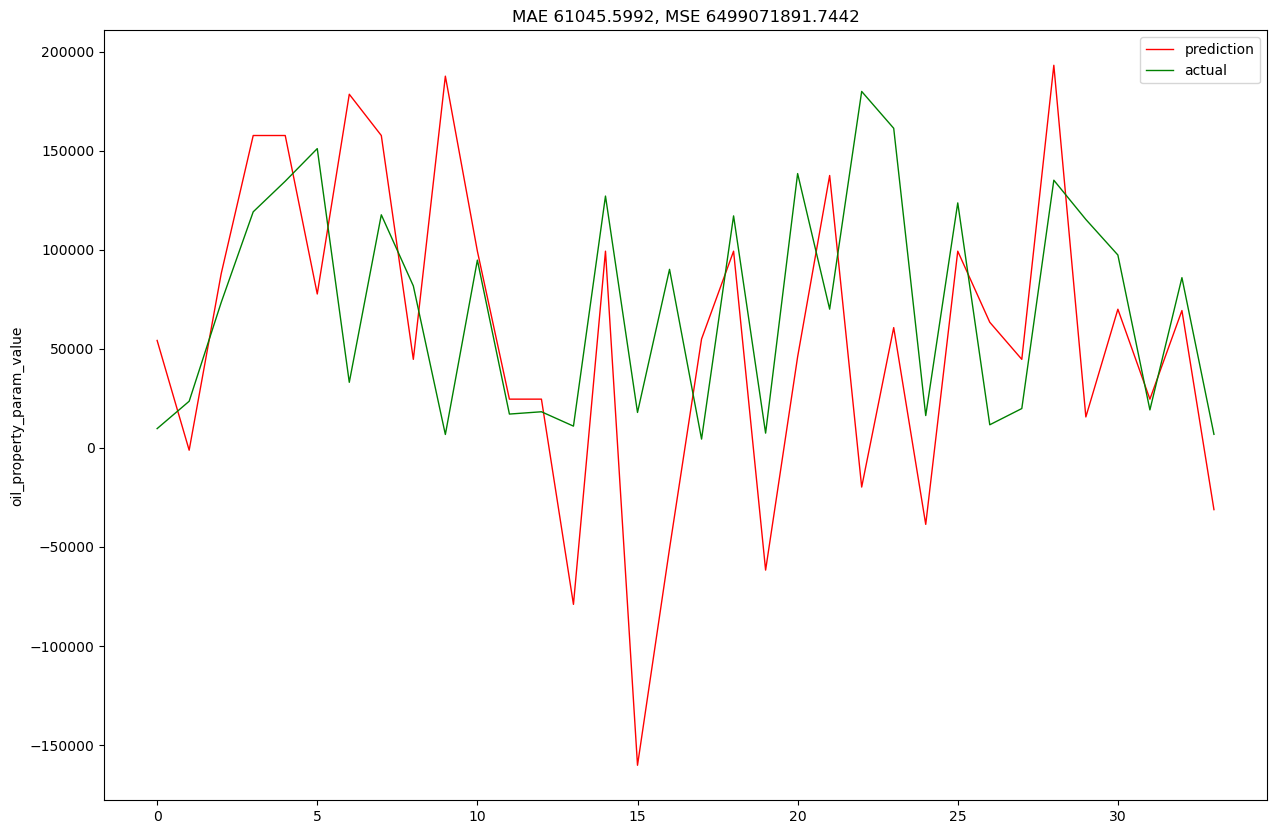

MAE score: 61045.5992
MSE score: 6499071891.7442


In [10]:
nn_model = SmallNN(X=dataset.data_x.reshape(338, 690), y=dataset.data_y.reshape(338,))
nn_model.fit_and_evaluate()

In [13]:
from sklearn.model_selection import train_test_split
scaler_ = StandardScaler() # RobustScaler

regressor = LstmRegressor(units=50, dropout_rate=0.001, optimizer='rmsprop', epochs=200, 
                          batch_size=8, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

X_train, X_test, y_train, y_test = train_test_split(
            dataset.data_x.reshape(338, 690), dataset.data_y.reshape(338,), test_size=0.1, random_state=42
        )
model, _ = regressor.fit(X_train, y_train, X_test, y_test)

Epoch 1/200
38/38 [==============================] - 65s 2s/step - loss: 1.0065 - val_loss: 0.4040 - lr: 0.0010
Epoch 2/200
38/38 [==============================] - 57s 1s/step - loss: 1.0032 - val_loss: 0.4041 - lr: 0.0010
Epoch 3/200
12/38 [========>.....................] - ETA: 37s - loss: 1.8349